In [1]:
import copy
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import csv
from sklearn import tree
from itertools import *
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score, roc_auc_score
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import savgol_filter, argrelextrema
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [51]:
df_train = pd.read_csv('sales_train.csv')
df_test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
items_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [52]:
df_train = df_train.merge(items, on='item_id')
df_train = df_train.merge(items_categories, on='item_category_id')
df_train = df_train.merge(shops, on='shop_id')
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,26.06.2013,5,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,20.07.2013,6,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,14.09.2013,8,59,944,299.0,2.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
...,...,...,...,...,...,...,...,...,...,...
2935844,22.10.2015,33,55,13093,250.0,1.0,Карта оплаты Windows: 250 рублей [Цифровая вер...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935845,21.09.2015,32,55,13091,1000.0,1.0,Карта оплаты Windows: 1000 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935846,16.09.2015,32,55,13094,2500.0,1.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935847,22.09.2015,32,55,13094,2500.0,2.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн


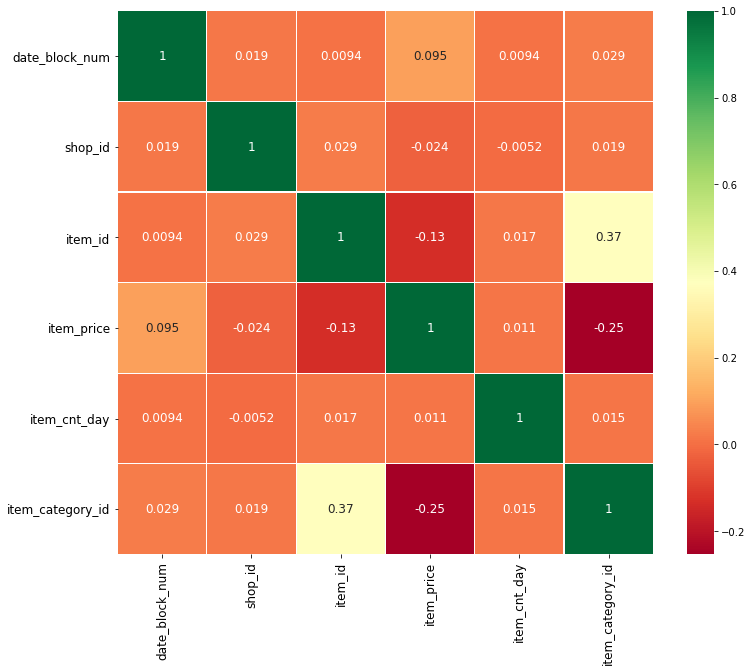

In [17]:
import seaborn as sns
sns.heatmap(df_train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':12})
fig=plt.gcf()
fig.set_size_inches(12,10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [53]:
df_train = df_train[df_train.item_price>0]
df_train = df_train[df_train.item_price<100000]
df_train = df_train[df_train.item_cnt_day<1001]

In [54]:
# Якутск Орджоникидзе, 56
df_train.loc[df_train.shop_id == 0, 'shop_id'] = 57

# Якутск ТЦ "Центральный"
df_train.loc[df_train.shop_id == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м²
df_train.loc[df_train.shop_id == 10, 'shop_id'] = 11

In [55]:
df_train['city'] = df_train['shop_name'].str.split(' ').map(lambda x: x[0])

df_train.loc[df_train.city == 'Цифровой', 'city'] = 'Интернет-магазин'
df_train.loc[df_train.city == '!Якутск', 'city'] = 'Якутск'

In [56]:
df_train['type'] = df_train['item_category_name'].str.split(' - ').map(lambda x: x[0])
df_train['subtype'] = df_train['item_category_name'].str.split(' - ').map(lambda x: x[-1])

df_train.drop(['item_category_name', 'item_category_id'], axis=1, inplace=True)

In [57]:
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,shop_name,city,type,subtype
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),"Ярославль ТЦ ""Альтаир""",Ярославль,Кино,Blu-Ray
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),"Ярославль ТЦ ""Альтаир""",Ярославль,Кино,Blu-Ray
2,26.06.2013,5,59,944,199.5,1.0,2012 (BD),"Ярославль ТЦ ""Альтаир""",Ярославль,Кино,Blu-Ray
3,20.07.2013,6,59,944,199.5,1.0,2012 (BD),"Ярославль ТЦ ""Альтаир""",Ярославль,Кино,Blu-Ray
4,14.09.2013,8,59,944,299.0,2.0,2012 (BD),"Ярославль ТЦ ""Альтаир""",Ярославль,Кино,Blu-Ray
...,...,...,...,...,...,...,...,...,...,...,...
2935844,22.10.2015,33,55,13093,250.0,1.0,Карта оплаты Windows: 250 рублей [Цифровая вер...,Цифровой склад 1С-Онлайн,Интернет-магазин,Карты оплаты,Windows (Цифра)
2935845,21.09.2015,32,55,13091,1000.0,1.0,Карта оплаты Windows: 1000 рублей [Цифровая ве...,Цифровой склад 1С-Онлайн,Интернет-магазин,Карты оплаты,Windows (Цифра)
2935846,16.09.2015,32,55,13094,2500.0,1.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,Цифровой склад 1С-Онлайн,Интернет-магазин,Карты оплаты,Windows (Цифра)
2935847,22.09.2015,32,55,13094,2500.0,2.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,Цифровой склад 1С-Онлайн,Интернет-магазин,Карты оплаты,Windows (Цифра)


In [35]:
print(set(df_train.item_category_name.values))

{'Игры - XBOX ONE', 'Игры - PSP', 'Игровые консоли - Прочие', 'Подарки - Гаджеты, роботы, спорт', 'Игры Android - Цифра', 'Подарки - Мягкие игрушки', 'Карты оплаты - Windows (Цифра)', 'Музыка - MP3', 'Книги - Артбуки, энциклопедии', 'PC - Гарнитуры/Наушники', 'Программы - Для дома и офиса', 'Игры PC - Стандартные издания', 'Игровые консоли - PS4', 'Подарки - Сувениры (в навеску)', 'Чистые носители (штучные)', 'Элементы питания', 'Билеты (Цифра)', 'Игры PC - Дополнительные издания', 'Музыка - Винил', 'Книги - Аудиокниги (Цифра)', 'Служебные - Билеты', 'Игры - PS3', 'Музыка - CD локального производства', 'Книги - Аудиокниги 1С', 'Подарки - Сертификаты, услуги', 'Книги - Открытки', 'Книги - Цифра', 'Музыка - Подарочные издания', 'Музыка - CD фирменного производства', 'Книги - Комиксы, манга', 'Программы - Обучающие', 'Аксессуары - XBOX ONE', 'Карты оплаты - PSN', 'Игровые консоли - PS3', 'Чистые носители (шпиль)', 'Книги - Компьютерная литература', 'Программы - Обучающие (Цифра)', 'Подарк

In [31]:
df_train.city[df_train.city == 'Цифровой'] = 'Интернет-магазин'
df_train.city[df_train.city == '!Якутск'] = 'Якутск'

In [60]:
print(np.unique(df_train.subtype))

['1С:Предприятие 8' 'Blu-Ray' 'Blu-Ray 3D' 'Blu-Ray 4K'
 'CD локального производства' 'CD фирменного производства' 'DVD' 'Live!'
 'Live! (Цифра)' 'MAC (Цифра)' 'MP3' 'PS2' 'PS3' 'PS4' 'PSN' 'PSP'
 'PSVita' 'Windows (Цифра)' 'XBOX 360' 'XBOX ONE' 'Аксессуары для игр'
 'Артбуки, энциклопедии' 'Атрибутика' 'Аудиокниги' 'Аудиокниги (Цифра)'
 'Аудиокниги 1С' 'Бизнес литература' 'Билеты' 'Билеты (Цифра)' 'Винил'
 'Гаджеты, роботы, спорт' 'Гарнитуры/Наушники' 'Для дома и офиса'
 'Для дома и офиса (Цифра)' 'Дополнительные издания' 'Доставка товара'
 'Карты оплаты (Кино, Музыка, Игры)' 'Коллекционное'
 'Коллекционные издания' 'Комиксы, манга' 'Компьютерная литература'
 'Методические материалы 1С' 'Музыкальное видео' 'Мягкие игрушки'
 'Настольные игры' 'Настольные игры (компактные)' 'Обучающие'
 'Обучающие (Цифра)' 'Открытки' 'Открытки, наклейки' 'Подарочные издания'
 'Познавательная литература' 'Прочие' 'Путеводители' 'Развитие'
 'Сертификаты, услуги' 'Служебные' 'Стандартные издания' 'Сувениры